In [1]:
# Part 1: Imports and Setup
import pandas as pd
import numpy as np
import openai
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, OneClassSVM
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, MaxPooling1D, concatenate
from tensorflow.keras.models import Model
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                           roc_auc_score, precision_recall_curve, auc,
                           classification_report, confusion_matrix)
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import defaultdict

2024-11-07 11:20:12.439540: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 11:20:12.451522: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730949612.467004   13772 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730949612.471556   13772 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 11:20:12.487876: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
#cicddos_df = pd.read_csv('notProcessed_FullFeature_AttackTypes.csv')
binary_ddos_df = pd.read_csv('Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

In [3]:
print("\nBinary DDoS Dataset Head:")
binary_ddos_df.head()


Binary DDoS Dataset Head:


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.5-104.16.207.165-54865-443-6,104.16.207.165,443,192.168.10.5,54865,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,192.168.10.5-104.16.28.216-55054-80-6,104.16.28.216,80,192.168.10.5,55054,6,7/7/2017 3:30,109,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,192.168.10.5-104.16.28.216-55055-80-6,104.16.28.216,80,192.168.10.5,55055,6,7/7/2017 3:30,52,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,192.168.10.16-104.17.241.25-46236-443-6,104.17.241.25,443,192.168.10.16,46236,6,7/7/2017 3:30,34,1,1,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,192.168.10.5-104.19.196.102-54863-443-6,104.19.196.102,443,192.168.10.5,54863,6,7/7/2017 3:30,3,2,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [4]:
binary_ddos_df.columns = binary_ddos_df.columns.str.strip()
binary_ddos_df['Timestamp'] = pd.to_datetime(binary_ddos_df['Timestamp'])

In [5]:
binary_ddos_df.describe()

/home/ecs-user/is5126/final-project/.venv/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/ecs-user/is5126/final-project/.venv/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Source Port,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,225745.000000,225745.00000,225745.000000,225745,2.257450e+05,225745.000000,225745.000000,225745.000000,2.257450e+05,225745.000000,...,225745.000000,225745.000000,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05
mean,38257.568402,8879.61946,7.600288,2017-07-07 04:07:42.454628096,1.624165e+07,4.874916,4.572775,939.463346,5.960477e+03,538.535693,...,3.311497,21.482753,1.848261e+05,1.293436e+04,2.080849e+05,1.776201e+05,1.032214e+07,3.611943e+06,1.287813e+07,7.755355e+06
min,0.000000,0.00000,0.000000,2017-07-07 03:30:00,-1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,18990.000000,80.00000,6.000000,2017-07-07 04:00:00,7.118000e+04,2.000000,1.000000,26.000000,0.000000e+00,6.000000,...,1.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,49799.000000,80.00000,6.000000,2017-07-07 04:06:00,1.452333e+06,3.000000,4.000000,30.000000,1.640000e+02,20.000000,...,2.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,58296.000000,80.00000,6.000000,2017-07-07 04:13:00,8.805237e+06,5.000000,5.000000,63.000000,1.160100e+04,34.000000,...,4.000000,20.000000,1.878000e+03,0.000000e+00,1.878000e+03,1.862000e+03,8.239725e+06,0.000000e+00,8.253838e+06,7.422849e+06
max,65534.000000,65532.00000,17.000000,2017-07-07 05:02:00,1.199999e+08,1932.000000,2942.000000,183012.000000,5.172346e+06,11680.000000,...,1931.000000,52.000000,1.000000e+08,3.950000e+07,1.000000e+08,1.000000e+08,1.200000e+08,6.530000e+07,1.200000e+08,1.200000e+08
std,23057.302075,19754.64740,3.881586,NaN,3.152437e+07,15.422874,21.755356,3249.403484,3.921834e+04,1864.128991,...,12.270018,4.166799,7.979250e+05,2.102737e+05,9.002350e+05,7.842602e+05,2.185303e+07,1.275689e+07,2.692126e+07,1.983109e+07


In [6]:
binary_ddos_df[['Flow Bytes/s', 'Flow Packets/s']].max()

Flow Bytes/s      inf
Flow Packets/s    inf
dtype: float64

In [7]:
binary_ddos_df.isnull().sum()

Flow ID             0
Source IP           0
Source Port         0
Destination IP      0
Destination Port    0
                   ..
Idle Mean           0
Idle Std            0
Idle Max            0
Idle Min            0
Label               0
Length: 85, dtype: int64

In [8]:
binary_ddos_df.dropna(inplace=True)

In [9]:
# Columns with all zeros
temp = binary_ddos_df[binary_ddos_df == 0].count()
df_zero_columns = temp[temp == binary_ddos_df.shape[0]].index
print(df_zero_columns)

Index(['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'CWE Flag Count',
       'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate',
       'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'],
      dtype='object')


In [10]:
# Checking possible columns that are categorical
categorical_df = []
df_one_values = []
for x in binary_ddos_df.columns:
    count = binary_ddos_df[x].value_counts().count()
    if count < 20:
        print(f"{x}\t: {count}")
        categorical_df.append(x)
        if count == 1:
            df_one_values.append(x)

Protocol	: 3
Fwd PSH Flags	: 2
Bwd PSH Flags	: 1
Fwd URG Flags	: 1
Bwd URG Flags	: 1
FIN Flag Count	: 2
SYN Flag Count	: 2
RST Flag Count	: 2
PSH Flag Count	: 2
ACK Flag Count	: 2
URG Flag Count	: 2
CWE Flag Count	: 1
ECE Flag Count	: 2
Down/Up Ratio	: 8
Fwd Avg Bytes/Bulk	: 1
Fwd Avg Packets/Bulk	: 1
Fwd Avg Bulk Rate	: 1
Bwd Avg Bytes/Bulk	: 1
Bwd Avg Packets/Bulk	: 1
Bwd Avg Bulk Rate	: 1
min_seg_size_forward	: 8
Label	: 2


In [11]:
binary_ddos_df_feature = binary_ddos_df.drop(columns=['Destination IP', 'Source IP', 'Flow ID', 'Fwd Header Length.1', 'Timestamp'])

# Drop any rows with nulls
print(f"Dropping {binary_ddos_df_feature.isnull().any(axis=1).sum()} rows with null value...")
binary_ddos_df_feature = binary_ddos_df_feature.drop(index=binary_ddos_df_feature[binary_ddos_df_feature.isnull().any(axis=1)].index)

# Drop any rows with infinity
print(f"Dropping {binary_ddos_df_feature.isnull().any(axis=1).sum()} rows with infinity value...")
binary_ddos_df_feature = binary_ddos_df_feature.drop(index=binary_ddos_df_feature[binary_ddos_df_feature.isin([np.inf, -np.inf]).any(axis=1)].index)

# Dropping columns with only 1 value
print(f"Dropping {len(df_one_values)} columns with only 1 value...")
binary_ddos_df_feature = binary_ddos_df_feature.drop(columns=df_one_values)

# Change flag columns to boolean type
to_bool = []
for x in binary_ddos_df_feature.columns:
    if "Flag" in x:
        to_bool.append(x)
print(f"Changing {len(to_bool)} columns to boolean...")
binary_ddos_df_feature[to_bool] = binary_ddos_df_feature[to_bool].astype('bool')

# Encode Protocol become categorical
print("Changing Protocol value to categorical with one hot encoding")
binary_ddos_df_feature = pd.get_dummies(binary_ddos_df_feature, columns=['Protocol'])


# Changing Label to Benign = 0 and DDoS = 1
#binary_ddos_df['Label'] = binary_ddos_df['Label'].apply(lambda x: 1 if x == "DDoS" else 0)
#binary_ddos_df['Label'] = binary_ddos_df['Label'].astype('bool')

Dropping 0 rows with null value...
Dropping 0 rows with infinity value...
Dropping 10 columns with only 1 value...
Changing 8 columns to boolean...
Changing Protocol value to categorical with one hot encoding


In [12]:
corr = binary_ddos_df_feature.select_dtypes('number').corr()
iterations = corr.columns
variance = binary_ddos_df_feature.select_dtypes('number').var()
mask = np.triu(corr)
columns_to_drop = set()
print("High Linear Correlations\n")
for i in range(len(iterations)):
    for j in range(i):
        if abs(corr.iloc[i,j]) >= 0.8:
            print(f"{iterations[i]} v {iterations[j]}: {corr.iloc[i,j]}\n")
            if variance[iterations[i]] > variance[iterations[j]]:
                columns_to_drop.add(iterations[j])
            else:
                columns_to_drop.add(iterations[i])
        else:
            mask[i,j] = 1

print(f"{len(columns_to_drop)} Columns to drop:\n")
print(columns_to_drop)            

High Linear Correlations

Total Backward Packets v Total Fwd Packets: 0.9567136244127366

Total Length of Bwd Packets v Total Fwd Packets: 0.9384697830686038

Total Length of Bwd Packets v Total Backward Packets: 0.9704220582473646

Fwd Packet Length Max v Total Length of Fwd Packets: 0.8524252172780814

Fwd Packet Length Mean v Total Length of Fwd Packets: 0.8584367853292977

Fwd Packet Length Mean v Fwd Packet Length Max: 0.9409531839230566

Fwd Packet Length Std v Total Length of Fwd Packets: 0.8391376344888687

Fwd Packet Length Std v Fwd Packet Length Max: 0.9916724305463113

Fwd Packet Length Std v Fwd Packet Length Mean: 0.9196308911619513

Bwd Packet Length Mean v Bwd Packet Length Max: 0.9614403503257678

Bwd Packet Length Std v Bwd Packet Length Max: 0.992682972600315

Bwd Packet Length Std v Bwd Packet Length Mean: 0.9560052955625107

Flow IAT Std v Flow Duration: 0.8991755549188647

Flow IAT Std v Flow IAT Mean: 0.9175261684823027

Flow IAT Max v Flow Duration: 0.9202541443

In [13]:
# Dropping columns with high correlation
binary_ddos_df_feature = binary_ddos_df_feature.drop(columns=columns_to_drop)

In [14]:
binary_ddos_df_feature.describe()

,Source Port,Destination Port,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Min,Bwd Packet Length Min,Flow Bytes/s,Flow Packets/s,Flow IAT Min,Fwd IAT Total,...,Bwd Packets/s,Min Packet Length,Packet Length Variance,Down/Up Ratio,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward,Active Std,Active Max,Idle Std
count,225711.000000,225711.000000,225711.000000,2.257110e+05,225711.000000,225711.000000,2.257110e+05,2.257110e+05,2.257110e+05,2.257110e+05,...,2.257110e+05,225711.000000,2.257110e+05,225711.000000,225711.000000,225711.000000,225711.000000,2.257110e+05,2.257110e+05,2.257110e+05
mean,38260.251042,8876.556769,939.603147,5.961369e+03,27.885810,16.715043,5.853939e+05,1.424120e+04,2.812278e+04,1.539884e+07,...,1.641940e+03,8.073226,2.790323e+06,1.005932,4247.836184,600.838165,21.482338,1.293631e+04,2.081162e+05,3.612487e+06
std,23056.127737,19752.018851,3249.628245,3.922122e+04,163.336194,50.402988,1.688552e+07,1.151042e+05,7.598672e+05,3.161007e+07,...,1.989742e+04,15.768778,4.116110e+06,1.430850,8038.078845,4317.877742,4.166228,2.102894e+05,9.002992e+05,1.275778e+07
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-1.200000e+07,-2.000000e+06,-1.200000e+01,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,0.000000,-1.000000,-1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,18995.500000,80.000000,26.000000,0.000000e+00,0.000000,0.000000,1.208189e+01,6.184945e-01,1.000000e+00,1.310000e+02,...,3.640078e-02,0.000000,0.000000e+00,0.000000,229.000000,-1.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00
50%,49800.000000,80.000000,30.000000,1.640000e+02,0.000000,0.000000,1.133466e+03,5.175421e+00,3.000000e+00,2.373900e+04,...,1.485517e+00,0.000000,2.378127e+04,1.000000,256.000000,126.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00
75%,58297.000000,80.000000,64.000000,1.160100e+04,6.000000,6.000000,2.158024e+04,7.035614e+01,3.900000e+01,7.871715e+06,...,2.103068e+01,6.000000,4.544874e+06,1.000000,8192.000000,229.000000,20.000000,0.000000e+00,1.879000e+03,0.000000e+00
max,65534.000000,65532.000000,183012.000000,5.172346e+06,1472.000000,1460.000000,2.070000e+09,3.000000e+06,1.070000e+08,1.200000e+08,...,2.000000e+06,337.000000,2.240000e+07,7.000000,65535.000000,65535.000000,52.000000,3.950000e+07,1.000000e+08,6.530000e+07


In [15]:
binary_ddos_df_feature.columns

Index(['Source Port', 'Destination Port', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Min',
       'Bwd Packet Length Min', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Min', 'Fwd IAT Total', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Fwd PSH Flags', 'Bwd Packets/s', 'Min Packet Length',
       'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count',
       'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count',
       'ECE Flag Count', 'Down/Up Ratio', 'Init_Win_bytes_forward',
       'Init_Win_bytes_backward', 'min_seg_size_forward', 'Active Std',
       'Active Max', 'Idle Std', 'Label', 'Protocol_0', 'Protocol_6',
       'Protocol_17'],
      dtype='object')

In [16]:
binary_ddos_df_feature[['Flow Bytes/s', 'Flow Packets/s']].max()

Flow Bytes/s      2.070000e+09
Flow Packets/s    3.000000e+06
dtype: float64

In [17]:
binary_ddos_df_feature['Label'].unique()

array(['BENIGN', 'DDoS'], dtype=object)

In [18]:
# Convert 'Label' to binary (0/1) if it's categorical
binary_ddos_df_feature['Label'] = binary_ddos_df_feature['Label'].map({'DDoS': 1, 'BENIGN': 0})  

# Check if 'Label' column is now binary numeric
if not binary_ddos_df_feature['Label'].dtype in ['int64', 'float64']:
    raise ValueError("The 'Label' column is not binary numeric. Please ensure it contains only 0s and 1s.")

# Initialize a list to keep track of columns to drop
columns_to_drop_2 = []

# Loop through numeric columns in binary_ddos_df
print("Low correlation numerical features with Label\n")
for x in binary_ddos_df_feature.select_dtypes('number').columns:
    # Ensure the current column is numeric
    if pd.api.types.is_numeric_dtype(binary_ddos_df_feature[x]):
        try:
            # Calculate Point-Biserial correlation
            temp = stats.pointbiserialr(binary_ddos_df_feature[x], binary_ddos_df_feature['Label'])
            
            # Check if the absolute correlation is below the threshold (0.1)
            if abs(temp.statistic) < 0.1:
                print(f"{x}\t: {temp.statistic}")
                columns_to_drop_2.append(x)
        except Exception as e:
            print(f"Error computing correlation for column {x}: {e}")
    else:
        print(f"Skipping non-numeric column: {x}")

# Drop columns with low correlation
print(f"Dropping {len(columns_to_drop_2)} columns...")
binary_ddos_df_feature = binary_ddos_df_feature.drop(columns=columns_to_drop_2)

# Optionally: Display the DataFrame after column removal
print(f"Remaining columns: {binary_ddos_df_feature.columns.tolist()}")


Low correlation numerical features with Label

Total Length of Bwd Packets	: 0.04122490275548876
Flow Bytes/s	: -0.03554493545691383
Flow IAT Min	: -0.038689705994943216
Fwd IAT Total	: 0.04049423866605308
Bwd Packets/s	: -0.09040487871804291
Init_Win_bytes_forward	: -0.05097124361890766
Active Std	: -0.07042469740266522
Active Max	: -0.009307613028294063
Idle Std	: 0.07798758182197794
Dropping 9 columns...
Remaining columns: ['Source Port', 'Destination Port', 'Total Length of Fwd Packets', 'Fwd Packet Length Min', 'Bwd Packet Length Min', 'Flow Packets/s', 'Bwd IAT Total', 'Bwd IAT Mean', 'Fwd PSH Flags', 'Min Packet Length', 'Packet Length Variance', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'ECE Flag Count', 'Down/Up Ratio', 'Init_Win_bytes_backward', 'min_seg_size_forward', 'Label', 'Protocol_0', 'Protocol_6', 'Protocol_17']


In [19]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif

# Checking if there is any significant dependency between categorical features with target
chi2_stats, p_values = chi2(binary_ddos_df_feature.drop(columns=['Label']).select_dtypes('bool'), binary_ddos_df_feature['Label'])
columns = binary_ddos_df_feature.drop(columns=['Label']).select_dtypes('bool').columns
for i in range(len(columns)):
    print(f"{columns[i]}\t: p_value={p_values[i]}")

Fwd PSH Flags	: p_value=0.0
FIN Flag Count	: p_value=2.098426458812254e-146
SYN Flag Count	: p_value=0.0
RST Flag Count	: p_value=2.7048311032787678e-09
PSH Flag Count	: p_value=0.0
ACK Flag Count	: p_value=2.5298218044405928e-231
URG Flag Count	: p_value=0.0
ECE Flag Count	: p_value=2.7048311032787678e-09
Protocol_0	: p_value=4.0116187262167116e-17
Protocol_6	: p_value=0.0
Protocol_17	: p_value=0.0


Text(0, 0.5, 'Features')

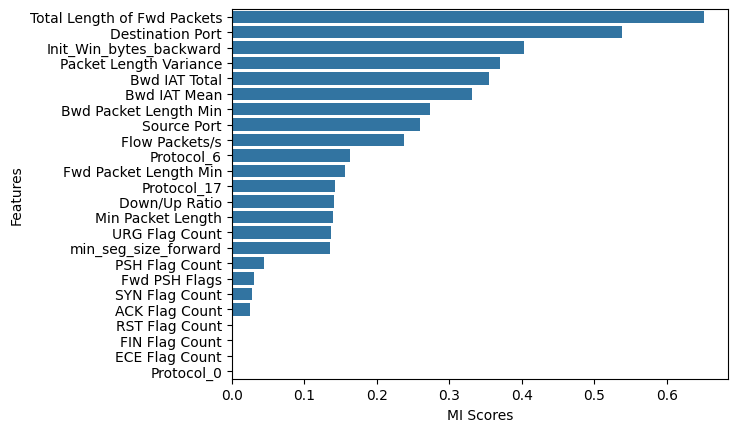

In [20]:
# Checking mutual information gain from features and target
mi_scores = mutual_info_classif(binary_ddos_df_feature.drop(columns=['Label']), binary_ddos_df_feature['Label'])
mi_scores = pd.Series(mi_scores, name="MI Scores", index=binary_ddos_df_feature.drop(columns=['Label']).columns)
mi_scores = mi_scores.sort_values(ascending=False)

sns.barplot(x=mi_scores, y=mi_scores.index)
plt.ylabel('Features')

In [21]:
# Tagging columns with the least information gain (Mostly due to close to zero variation in values)
columns_to_drop_3 = ['FIN Flag Count', 'RST Flag Count', 'ECE Flag Count']

In [22]:
binary_ddos_df_feature.head()

,Source Port,Destination Port,Total Length of Fwd Packets,Fwd Packet Length Min,Bwd Packet Length Min,Flow Packets/s,Bwd IAT Total,Bwd IAT Mean,Fwd PSH Flags,Min Packet Length,...,ACK Flag Count,URG Flag Count,ECE Flag Count,Down/Up Ratio,Init_Win_bytes_backward,min_seg_size_forward,Label,Protocol_0,Protocol_6,Protocol_17
0,443,54865,12,6,0,666666.66670,0,0.0,False,6,...,True,False,False,0,-1,20,0,False,True,False
1,80,55054,6,6,6,18348.62385,0,0.0,False,6,...,True,True,False,1,256,20,0,False,True,False
2,80,55055,6,6,6,38461.53846,0,0.0,False,6,...,True,True,False,1,256,20,0,False,True,False
3,443,46236,6,6,6,58823.52941,0,0.0,False,6,...,True,True,False,1,329,20,0,False,True,False
4,443,54863,12,6,0,666666.66670,0,0.0,False,6,...,True,False,False,0,-1,20,0,False,True,False


In [23]:
categorical_column = binary_ddos_df_feature.select_dtypes('bool').columns
numerical_columns = binary_ddos_df_feature.select_dtypes('number').columns

## ML

In [24]:
def load_and_preprocess_data(df, is_binary=True):
    
    df = df.drop(columns=['Destination IP', 'Source IP', 'Flow ID', 'Fwd Header Length.1'])
    # Drop any rows with nulls
    df = df.drop(index=df[df.isnull().any(axis=1)].index)
    # Drop any rows with infinity
    df = df.drop(index=df[df.isin([np.inf, -np.inf]).any(axis=1)].index)
    # Dropping columns with only 1 value
    df = df.drop(columns=df_one_values)
    # Dropping columns with high colinearity
    df = df.drop(columns=columns_to_drop)
    # Dropping columns that have low correlation with target
    df = df.drop(columns=columns_to_drop_2)
    # Dropping columns that have low mutual information gain with target
    df = df.drop(columns=columns_to_drop_3)

    # Changing Label to 0 and 1
    df['Label'] = df['Label'].map({'DDoS': 1, 'BENIGN': 0})  
    
    # Feature engineering
    if 'Timestamp' in df.columns:
        df['hour'] = pd.to_datetime(df['Timestamp']).dt.hour
        df['day_of_week'] = pd.to_datetime(df['Timestamp']).dt.dayofweek
        df.drop('Timestamp', axis=1, inplace=True)
    
    # Separate features and target
    X = df.drop('Label', axis=1)
    y = df['Label']
    
    return train_test_split(X, y, test_size=0.3, random_state=42)

def create_supervised_pipelines():
    """
    Create supervised learning pipelines
    """
    pipelines = {
        'random_forest': Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
        ]),
        'gradient_boosting': Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', GradientBoostingClassifier(random_state=42))
        ]),
        'svm': Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', SVC(kernel='rbf', probability=True, random_state=42))
        ]),
        'xgboost': Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', xgb.XGBClassifier(random_state=42))
        ])
    }
    return pipelines

def create_unsupervised_pipelines():
    """
    Create unsupervised learning pipelines
    """
    pipelines = {
        'kmeans': Pipeline([
            ('scaler', StandardScaler()),
            ('cluster', KMeans(n_clusters=2, random_state=42))
        ]),
        'dbscan': Pipeline([
            ('scaler', StandardScaler()),
            ('cluster', DBSCAN(eps=0.3, min_samples=10))
        ]),
        'isolation_forest': Pipeline([
            ('scaler', StandardScaler()),
            ('detector', IsolationForest(random_state=42))
        ]),
        'gmm': Pipeline([
            ('scaler', StandardScaler()),
            ('cluster', GaussianMixture(n_components=2, random_state=42))
        ])
    }
    return pipelines

def create_timeseries_pipeline(sequence_length=10):
    """
    Create time series based pipeline using LSTM
    """
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(sequence_length, None)),
        tf.keras.layers.LSTM(50),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def calculate_metrics(y_true, y_pred, y_prob=None):
    """
    Calculate comprehensive metrics for model evaluation
    """
    metrics = {}
    
    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['f1_score'] = f1_score(y_true, y_pred, average='weighted')
    metrics['precision'] = precision_score(y_true, y_pred, average='weighted')
    metrics['recall'] = recall_score(y_true, y_pred, average='weighted')
    
    # ROC-AUC and PR-AUC (only if probabilities are available)
    if y_prob is not None:
        metrics['roc_auc'] = roc_auc_score(y_true, y_prob)
        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        metrics['pr_auc'] = auc(recall, precision)
    
    return metrics

class MetricsTracker:
    """
    Track and store metrics for all models
    """
    def __init__(self):
        self.metrics = defaultdict(dict)
    
    def add_metrics(self, model_name, metrics_dict):
        self.metrics[model_name].update(metrics_dict)
    
    def get_summary_df(self):
        return pd.DataFrame.from_dict(self.metrics, orient='index')
    
    def plot_metrics_comparison(self):
        df = self.get_summary_df()
        
        plt.figure(figsize=(15, 8))
        df.plot(kind='bar')
        plt.title('Model Metrics Comparison')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

def train_and_evaluate_supervised(X_train, X_test, y_train, y_test, tracker):
    """
    Train and evaluate supervised models
    """
    pipelines = create_supervised_pipelines()
    
    for name, pipeline in pipelines.items():
        print(f"\nTraining {name}...")
        pipeline.fit(X_train, y_train)
        
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1]
        
        metrics = calculate_metrics(y_test, y_pred, y_prob)
        tracker.add_metrics(f"supervised_{name}", metrics)
        
        print(f"\nDetailed Classification Report for {name}:")
        print(classification_report(y_test, y_pred))

def train_and_evaluate_unsupervised(X_train, X_test, y_train, y_test, tracker):
    """
    Train and evaluate unsupervised models
    """
    pipelines = create_unsupervised_pipelines()
    
    for name, pipeline in pipelines.items():
        print(f"\nTraining {name}...")
        pipeline.fit(X_train)
        
        y_pred = pipeline.predict(X_test)
        
        # Convert predictions to binary format if needed
        if name in ['isolation_forest']:
            y_pred = (y_pred == 1).astype(int)
        
        metrics = calculate_metrics(y_test, y_pred)
        tracker.add_metrics(f"unsupervised_{name}", metrics)

def train_and_evaluate_timeseries(X_train, X_test, y_train, y_test, sequence_length=10, tracker=None):
    """
    Train and evaluate time series model
    """
    # Prepare sequences
    def create_sequences(X, y, sequence_length):
        X_seq, y_seq = [], []
        for i in range(len(X) - sequence_length):
            X_seq.append(X[i:(i + sequence_length)])
            y_seq.append(y[i + sequence_length])
        return np.array(X_seq), np.array(y_seq)
    
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)
    
    model = create_timeseries_pipeline(sequence_length)
    model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, verbose=0)
    
    y_pred = (model.predict(X_test_seq) > 0.5).astype(int)
    y_prob = model.predict(X_test_seq)
    
    metrics = calculate_metrics(y_test_seq, y_pred, y_prob)
    tracker.add_metrics("timeseries_lstm", metrics)

def main():
    # Initialize metrics tracker
    tracker = MetricsTracker()
    
    # Load and preprocess data
    # Replace with your actual file paths
    X_train, X_test, y_train, y_test = load_and_preprocess_data(binary_ddos_df)
    
    # Train and evaluate all models
    #train_and_evaluate_supervised(X_train, X_test, y_train, y_test, tracker)
    train_and_evaluate_unsupervised(X_train, X_test, y_train, y_test, tracker)
    #train_and_evaluate_timeseries(X_train, X_test, y_train, y_test, tracker=tracker)
    
    # Display results
    print("\nFinal Metrics Summary:")
    print(tracker.get_summary_df())
    
    # Plot metrics comparison
    tracker.plot_metrics_comparison()

if __name__ == "__main__":
    main()

## Unsupervised Learning

In [25]:
def load_and_preprocess_data_unsupervised(df, is_binary=True):
    
    df = df.drop(columns=['Destination IP', 'Source IP', 'Flow ID', 'Fwd Header Length.1'])
    # Drop any rows with nulls
    df = df.drop(index=df[df.isnull().any(axis=1)].index)
    # Drop any rows with infinity
    df = df.drop(index=df[df.isin([np.inf, -np.inf]).any(axis=1)].index)
    # Dropping columns with only 1 value
    df = df.drop(columns=df_one_values)
    # Dropping columns with high colinearity
    df = df.drop(columns=columns_to_drop)
    # Dropping columns that have low correlation with target
    df = df.drop(columns=columns_to_drop_2)
    # Dropping columns that have low mutual information gain with target
    df = df.drop(columns=columns_to_drop_3)

    # Changing Label to 0 and 1
    df['Label'] = df['Label'].map({'DDoS': 1, 'BENIGN': 0})  
    
    # Feature engineering
    if 'Timestamp' in df.columns:
        df['hour'] = pd.to_datetime(df['Timestamp']).dt.hour
        df['day_of_week'] = pd.to_datetime(df['Timestamp']).dt.dayofweek
        df.drop('Timestamp', axis=1, inplace=True)
    
    # Separate features and target
    X = df.drop('Label', axis=1)
    y = df['Label']
    
    return X

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
import numpy as np
import torch
import torch.nn as nn
import pickle

# Define parameter grids for each model
unsupervised_param_grids = {
    'kmeans': {'detector__n_clusters': [2,3, 5, 7, 10]},
    'dbscan': {'detector__eps': [0.2, 0.5, 0.8], 'detector__min_samples': [5, 10]},
    'isolation_forest': {'detector__n_estimators': [50, 100], 'detector__max_samples': ['auto', 0.8], 'detector__contamination': [0.1, 0.2]},
    'one_class_svm': {'detector__kernel': ['rbf', 'linear'], 'detector__nu': [0.1, 0.5], 'detector__gamma': ['scale', 'auto']},
    'gaussian_mixture': {'detector__n_components': [2, 3, 5, 7], 'detector__covariance_type': ['full', 'tied', 'diag', 'spherical']},
    'autoencoder': {'detector__hidden_size': [64, 128], 'detector__learning_rate': [0.001, 0.01], 'detector__n_epochs': [20, 50]}
}

# Define Autoencoder model class
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, int(hidden_size / 2)),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(int(hidden_size / 2), hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Autoencoder training function
def train_autoencoder(X, hidden_size=64, learning_rate=0.001, n_epochs=20):
    print(f"Training Autoencoder with hidden_size={hidden_size}, learning_rate={learning_rate}, n_epochs={n_epochs}")
    input_dim = X.shape[1]
    model = Autoencoder(input_dim=input_dim, hidden_size=hidden_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    X_tensor = torch.FloatTensor(X)

    for epoch in range(n_epochs):
        output = model(X_tensor)
        loss = criterion(output, X_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{n_epochs}, Loss: {loss.item():.6f}")
    return model

# Pipeline creation for unsupervised models
def create_unsupervised_pipelines():
    pipelines = {
        'kmeans': Pipeline([('scaler', StandardScaler()), ('detector', KMeans())]),
        'dbscan': Pipeline([('scaler', StandardScaler()), ('detector', DBSCAN())]),
        'isolation_forest': Pipeline([('scaler', StandardScaler()), ('detector', IsolationForest())]),
        'one_class_svm': Pipeline([('scaler', StandardScaler()), ('detector', OneClassSVM())]),
        'gaussian_mixture': Pipeline([('scaler', StandardScaler()), ('detector', GaussianMixture())]),
        'autoencoder': Pipeline([('scaler', MinMaxScaler()), ('detector', 'passthrough')])  # Autoencoder will be trained separately
    }
    print("Pipelines created for all unsupervised models.")
    return pipelines

# Tuning function for all models, including custom tuning for Autoencoder
def tune_and_save_unsupervised_models(X):
    pipelines = create_unsupervised_pipelines()
    best_models = {}
    
    for name, pipeline in pipelines.items():
        print(f"\nStarting tuning for {name}...")

        if name == 'autoencoder':  # Custom tuning for Autoencoder
            param_grid = unsupervised_param_grids['autoencoder']
            best_model, best_params, best_score = None, None, float('inf')
            
            for hidden_size in param_grid['detector__hidden_size']:
                for lr in param_grid['detector__learning_rate']:
                    for n_epochs in param_grid['detector__n_epochs']:
                        print(f"Testing Autoencoder with hidden_size={hidden_size}, learning_rate={lr}, n_epochs={n_epochs}")
                        model = train_autoencoder(X, hidden_size, lr, n_epochs)
                        X_tensor = torch.FloatTensor(X)
                        reconstructed = model(X_tensor).detach().numpy()
                        reconstruction_error = np.mean((X - reconstructed)**2)
                        print(f"Reconstruction error: {reconstruction_error:.6f}")

                        if reconstruction_error < best_score:
                            best_score = reconstruction_error
                            best_model = model
                            best_params = {
                                'hidden_size': hidden_size,
                                'learning_rate': lr,
                                'n_epochs': n_epochs
                            }
            
            # Save the best autoencoder
            best_models[name] = best_model
            with open(f'best_{name}_model.pkl', 'wb') as file:
                pickle.dump(best_model, file)
            print(f"Best params for {name}: {best_params}")
            print(f"Best score (reconstruction error) for {name}: {best_score}")

        else:  # Standard GridSearchCV for other models
            param_grid = unsupervised_param_grids.get(name, {})
            print(f"Running GridSearchCV for {name} with parameters: {param_grid}")
            grid_search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=3)
            grid_search.fit(X)
            
            # Save the best estimator
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            best_score = grid_search.best_score_
            
            print(f"Best params for {name}: {best_params}")
            print(f"Best score for {name}: {best_score}")
            
            # Save the best model to a pickle file
            with open(f'best_{name}_model.pkl', 'wb') as file:
                pickle.dump(best_model, file)
            
            best_models[name] = best_model
    
    print("Tuning and saving complete for all models.")
    return best_models

# Load and preprocess data (implement your own data loading function here)
X = load_and_preprocess_data_unsupervised(binary_ddos_df)

# Optional PCA for dimensionality reduction
print("Applying PCA for dimensionality reduction...")
X_reduced = PCA(n_components=10).fit_transform(X)  

# Run hyperparameter tuning and model saving for all unsupervised models
print("Starting hyperparameter tuning for all unsupervised models...")
best_unsupervised_models = tune_and_save_unsupervised_models(X_reduced)
print("Hyperparameter tuning and model saving completed.")

Applying PCA for dimensionality reduction...
Starting hyperparameter tuning for all unsupervised models...
Pipelines created for all unsupervised models.

Starting tuning for kmeans...
Running GridSearchCV for kmeans with parameters: {'detector__n_clusters': [2, 3, 5, 7, 10]}


/home/ecs-user/is5126/final-project/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ecs-user/is5126/final-project/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/ecs-user/is5126/final-project/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ecs-user/is5126/final-project/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estima

Best params for kmeans: {'detector__n_clusters': 2}
Best score for kmeans: nan

Starting tuning for dbscan...
Running GridSearchCV for dbscan with parameters: {'detector__eps': [0.2, 0.5, 0.8], 'detector__min_samples': [5, 10]}


/home/ecs-user/is5126/final-project/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ecs-user/is5126/final-project/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/ecs-user/is5126/final-project/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ecs-user/is5126/final-project/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estima

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, mean_squared_error
import numpy as np
import torch
import torch.nn as nn
import pickle

# Define parameter grids for each model
unsupervised_param_grids = {
    'kmeans': {'detector__n_clusters': [2, 3, 5, 7, 10]},
    'dbscan': {'detector__eps': [0.2, 0.5, 0.8], 'detector__min_samples': [5, 10]},
    'isolation_forest': {'detector__n_estimators': [50, 100], 'detector__max_samples': ['auto', 0.8], 'detector__contamination': [0.1, 0.2]},
    'one_class_svm': {'detector__kernel': ['rbf', 'linear'], 'detector__nu': [0.1, 0.5], 'detector__gamma': ['scale', 'auto']},
    'gaussian_mixture': {'detector__n_components': [2, 3, 5, 7], 'detector__covariance_type': ['full', 'tied', 'diag', 'spherical']},
    'autoencoder': {'detector__hidden_size': [64, 128], 'detector__learning_rate': [0.001, 0.01], 'detector__n_epochs': [20, 50]}
}

# Define Autoencoder model class
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, int(hidden_size / 2)),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(int(hidden_size / 2), hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Autoencoder training function
def train_autoencoder(X, hidden_size=64, learning_rate=0.001, n_epochs=20):
    print(f"Training Autoencoder with hidden_size={hidden_size}, learning_rate={learning_rate}, n_epochs={n_epochs}")
    input_dim = X.shape[1]
    model = Autoencoder(input_dim=input_dim, hidden_size=hidden_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    X_tensor = torch.FloatTensor(X)

    for epoch in range(n_epochs):
        output = model(X_tensor)
        loss = criterion(output, X_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{n_epochs}, Loss: {loss.item():.6f}")
    return model

# Pipeline creation for unsupervised models
def create_unsupervised_pipelines():
    pipelines = {
        'kmeans': Pipeline([('scaler', StandardScaler()), ('detector', KMeans())]),
        'dbscan': Pipeline([('scaler', StandardScaler()), ('detector', DBSCAN())]),
        'isolation_forest': Pipeline([('scaler', StandardScaler()), ('detector', IsolationForest())]),
        'one_class_svm': Pipeline([('scaler', StandardScaler()), ('detector', OneClassSVM())]),
        'gaussian_mixture': Pipeline([('scaler', StandardScaler()), ('detector', GaussianMixture())]),
        'autoencoder': Pipeline([('scaler', MinMaxScaler()), ('detector', 'passthrough')])  # Autoencoder will be trained separately
    }
    print("Pipelines created for all unsupervised models.")
    return pipelines

# Custom scoring function for clustering (Silhouette Score)
def silhouette_scoring(estimator, X):
    if hasattr(estimator, 'predict'):
        labels = estimator.predict(X)
    else:
        labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

# Custom scoring function for anomaly detection (Negative MSE)
def mse_scoring(estimator, X):
    if hasattr(estimator, 'predict'):
        y_pred = estimator.predict(X)
    else:
        y_pred = estimator.decision_function(X)
    return -mean_squared_error(X, y_pred)

# Tuning function for all models, including custom tuning for Autoencoder
def tune_and_save_unsupervised_models(X):
    pipelines = create_unsupervised_pipelines()
    best_models = {}
    
    for name, pipeline in pipelines.items():
        print(f"\nStarting tuning for {name}...")

        if name == 'autoencoder':  # Custom tuning for Autoencoder
            param_grid = unsupervised_param_grids['autoencoder']
            best_model, best_params, best_score = None, None, float('inf')
            
            for hidden_size in param_grid['detector__hidden_size']:
                for lr in param_grid['detector__learning_rate']:
                    for n_epochs in param_grid['detector__n_epochs']:
                        print(f"Testing Autoencoder with hidden_size={hidden_size}, learning_rate={lr}, n_epochs={n_epochs}")
                        model = train_autoencoder(X, hidden_size, lr, n_epochs)
                        X_tensor = torch.FloatTensor(X)
                        reconstructed = model(X_tensor).detach().numpy()
                        reconstruction_error = np.mean((X - reconstructed)**2)
                        print(f"Reconstruction error: {reconstruction_error:.6f}")

                        if reconstruction_error < best_score:
                            best_score = reconstruction_error
                            best_model = model
                            best_params = {
                                'hidden_size': hidden_size,
                                'learning_rate': lr,
                                'n_epochs': n_epochs
                            }
            
            # Save the best autoencoder
            best_models[name] = best_model
            with open(f'best_{name}_model.pkl', 'wb') as file:
                pickle.dump(best_model, file)
            print(f"Best params for {name}: {best_params}")
            print(f"Best score (reconstruction error) for {name}: {best_score}")

        else:  # Standard GridSearchCV for other models
            param_grid = unsupervised_param_grids.get(name, {})
            print(f"Running GridSearchCV for {name} with parameters: {param_grid}")
            
            # Use custom scoring functions
            if name in ['kmeans', 'dbscan', 'gaussian_mixture']:
                scoring = silhouette_scoring
            elif name in ['isolation_forest', 'one_class_svm']:
                scoring = mse_scoring
            else:
                scoring = None  # Default for models like Gaussian Mixture
            
            grid_search = GridSearchCV(pipeline, param_grid, scoring=scoring, cv=3)
            grid_search.fit(X)
            
            # Save the best estimator
            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            best_score = grid_search.best_score_
            
            print(f"Best params for {name}: {best_params}")
            print(f"Best score for {name}: {best_score}")
            
            # Save the best model to a pickle file
            with open(f'best_{name}_model.pkl', 'wb') as file:
                pickle.dump(best_model, file)
            
            best_models[name] = best_model
    
    print("Tuning and saving complete for all models.")
    return best_models

# Load and preprocess data (implement your own data loading function here)
X = load_and_preprocess_data_unsupervised(binary_ddos_df)

# Optional PCA for dimensionality reduction
print("Applying PCA for dimensionality reduction...")
X_reduced = PCA(n_components=10).fit_transform(X)  

# Run hyperparameter tuning and model saving for all unsupervised models
print("Starting hyperparameter tuning for all unsupervised models...")
best_unsupervised_models = tune_and_save_unsupervised_models(X_reduced)
print("Hyperparameter tuning and model saving completed.")